# Time-Series DL Model For Stock Price Prediction

In [2]:
from alpha_vantage.timeseries import TimeSeries
import json


def save_dataset(symbol):
    credentials = json.load(open('creds.json', 'r'))
    api_key = credentials['av_api_key']

    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol, outputsize='full')

    data.to_csv(f'./{symbol}_daily.csv')

In [8]:
import pandas as pd 
from sklearn import preprocessing
import numpy as np

history_points = 50

def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('date', axis=1)
    data = data.drop(0, axis=0)

    data = data.values

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    # using the last {history_points} open high close low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)
    
    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:,3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]
    
    technical_indicators = []
    for his in ohlcv_histories_normalised:
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 28)
        technical_indicators.append(np.array([sma,macd]))
    technical_indicators = np.array(technical_indicators)
    
    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0] 
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser


In [9]:
save_dataset("TSLA")


In [13]:
data = pd.read_csv("TSLA_daily.csv")
data = data.drop('date', axis=1)
data = data.drop(0, axis=0)

data = data.values
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)

# using the last {history_points} open high close low volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(next_day_open_values)
print(data)

[[2.57900000e+01 3.04192000e+01 2.33000000e+01 2.38300000e+01
  1.71871000e+07]
 [2.50000000e+01 2.59200000e+01 2.02700000e+01 2.19600000e+01
  8.21880000e+06]
 [2.30000000e+01 2.31000000e+01 1.87100000e+01 1.92000000e+01
  5.13980000e+06]
 ...
 [3.56000000e+02 3.68740000e+02 3.29880000e+02 3.30210000e+02
  1.15465691e+08]
 [3.56600000e+02 3.69000000e+02 3.41510000e+02 3.66280000e+02
  7.94657690e+07]
 [3.86210000e+02 3.98990000e+02 3.60560000e+02 3.71340000e+02
  8.49306080e+07]]


In [53]:
# ohlcv_histories, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('MSFT_daily.csv')
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('MSFT_daily.csv')
test_split = 0.9 # the percent of data to be used for testing
n = int(ohlcv_histories.shape[0] * test_split)


# Train
ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

# Test
ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

X_train = ohlcv_train
X_test = ohlcv_test
print(X_train.shape)

(4678, 50, 5)


In [54]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# New Model

In [26]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
from tensorflow import set_random_seed
set_random_seed(4)

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')
 
# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
# the second branch opreates on the second input
y = Dense(40, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)
 
# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
 
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)
 
# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

adam = optimizers.Adam(lr=0.001)

model.compile(optimizer=adam,
              loss='mse')



50


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
class StockPricePredictor(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockPricePredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=0.5)
        
        self.linear = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        lstm_out, (hn, cn) = self.lstm(x, (h0.detatch(), c0.detatch()))
        out = self.linear(lstm_out[:, -1, :])
        return out
    

In [63]:
model = StockPricePredictor(1, 32, 1, 2)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = optim.Adam(model.parameters(), lr=0.01)

In [64]:
hist = np.zeros(50)
lstm = []
for t in range(50):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    hist[t] = loss.item()
    print(f'Epoch {t} MSE: {loss.item()}')
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

AttributeError: 'Tensor' object has no attribute 'detatch'

In [48]:
def train_model(model, train_data, train_lavels, test_data=None, test_lavels=None):
    loss_fn = nn.MSELoss(reduction='sum')
    
    optimiser = optim.Adam(model.parameters(), lr=0.01)
    
    num_epochs = 50
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
#         model.reset_hidden_state()
        
        y_pred = model(X_train)
        
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        
        optimiser.zero_grad()
        
        loss.backward()
        
        optimiser.step()
    return mode.eval(), train_hist, test_hist
        

In [49]:
model = StockPricePredictor()

model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)

TypeError: view() takes at most 2 arguments (3 given)

In [41]:
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate([ohlcv_test, tech_ind_test], y_test)
print(evaluation)

AttributeError: 'StockPricePredictor' object has no attribute 'fit'

7.018367544530671


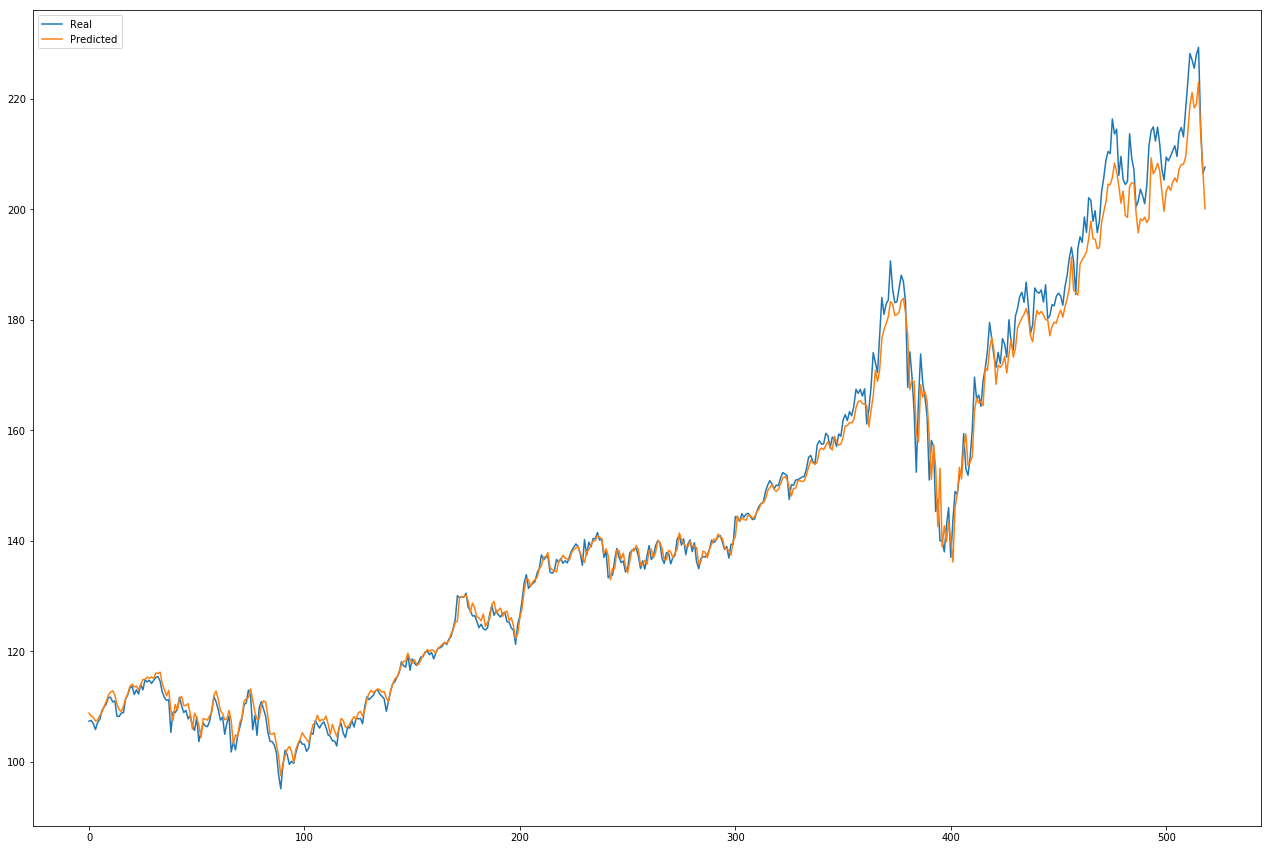

In [130]:
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])

y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

In [135]:
buys = []
sells = []
thresh = 0.3

x = 0
for ohlcv, ind in zip(ohlcv_test[start: end], tech_ind_test[start: end]):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = y_normaliser.inverse_transform(normalised_price_today)
    predicted = np.squeeze(y_normaliser.inverse_transform( model.predict([[ohlcv], [ind]])))
    delta = predicted - price_today
    # print(delta)
    if delta > thresh:
        buys.append((x, price_today[0][0]))
    elif delta < -thresh:
        sells.append((x, price_today[0][0]))
    x += 1
# print(buys)
# print(sells)

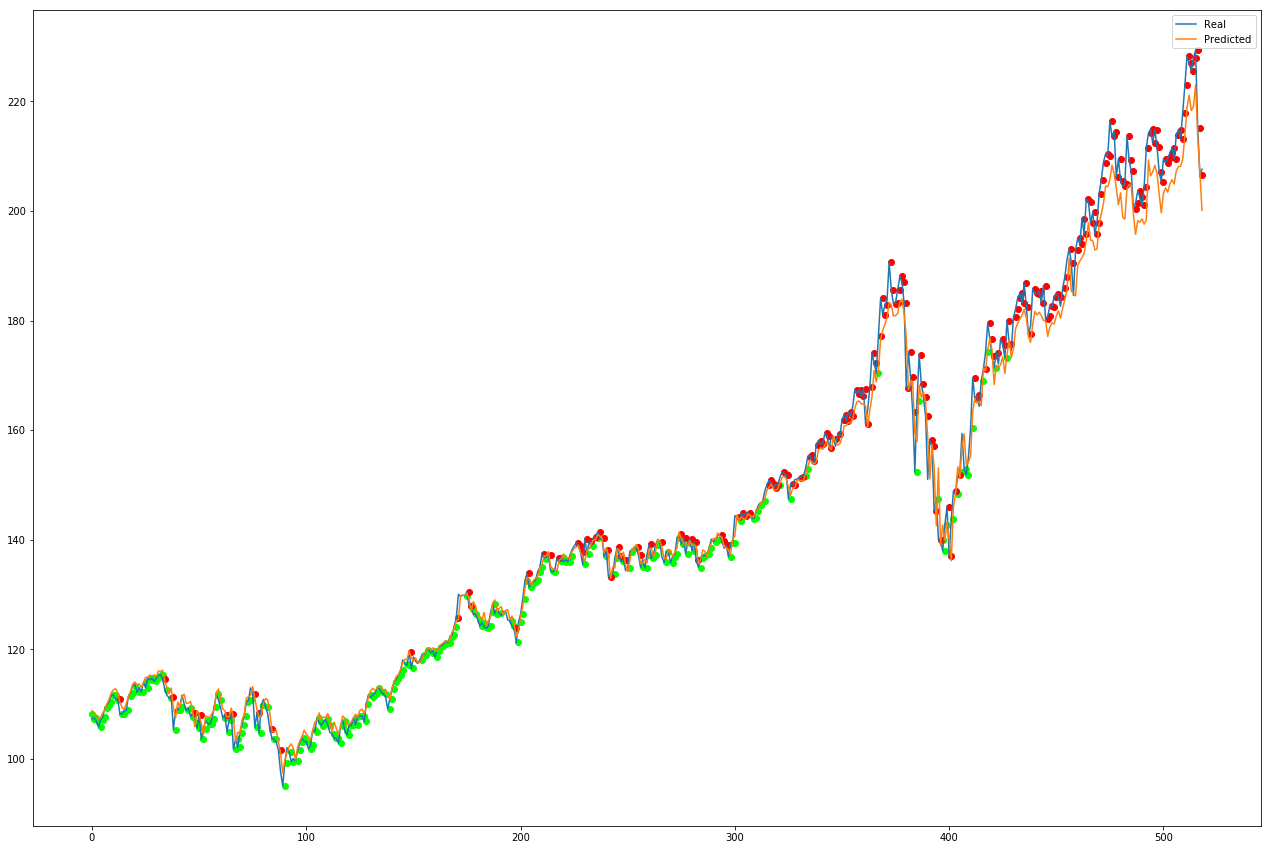

In [136]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00')
plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

In [137]:
def compute_earnings(buys, sells):
    purchase_amt = 100
    stock = 0
    balance = 0
    while len(buys) > 0 and len(sells) > 0:
        if buys[0][0] < sells[0][0]:
            # time to buy $10 worth of stock
            balance -= purchase_amt
            stock += purchase_amt / buys[0][1]
            buys.pop(0)
        else:
            # time to sell all of our stock
            balance += stock * sells[0][1]
            stock = 0
            sells.pop(0)
    print(balance)

In [138]:
compute_earnings([b for b in buys], [s for s in sells])

939.8653783387499
